<a href="https://colab.research.google.com/github/ShreyPandit/Brain_Image-Segmentation/blob/main/brain_image_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [ ]:
# Importing all the required libraries
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

import cv2
from tqdm import tqdm_notebook, tnrange
from glob import glob
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

import tensorflow as tf
from skimage.color import rgb2gray
from tensorflow.keras import Input
from tensorflow.keras.models import Model, load_model, save_model
from tensorflow.keras.layers import Input, Activation, BatchNormalization, Dropout, Lambda, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
# declaring the image dimensions
im_width = 256
im_height = 256


In [ ]:
# Separating all the images and mask from the dataset
train_files = []
mask_files = glob('../input/lgg-mri-segmentation/kaggle_3m/*/*_mask*')

for i in mask_files:
    train_files.append(i.replace('_mask',''))
    
print(train_files[:10])
print(mask_files[:10])

['../input/lgg-mri-segmentation/kaggle_3m/TCGA_CS_6669_20020102/TCGA_CS_6669_20020102_17.tif', '../input/lgg-mri-segmentation/kaggle_3m/TCGA_CS_6669_20020102/TCGA_CS_6669_20020102_4.tif', '../input/lgg-mri-segmentation/kaggle_3m/TCGA_CS_6669_20020102/TCGA_CS_6669_20020102_11.tif', '../input/lgg-mri-segmentation/kaggle_3m/TCGA_CS_6669_20020102/TCGA_CS_6669_20020102_19.tif', '../input/lgg-mri-segmentation/kaggle_3m/TCGA_CS_6669_20020102/TCGA_CS_6669_20020102_21.tif', '../input/lgg-mri-segmentation/kaggle_3m/TCGA_CS_6669_20020102/TCGA_CS_6669_20020102_18.tif', '../input/lgg-mri-segmentation/kaggle_3m/TCGA_CS_6669_20020102/TCGA_CS_6669_20020102_9.tif', '../input/lgg-mri-segmentation/kaggle_3m/TCGA_CS_6669_20020102/TCGA_CS_6669_20020102_22.tif', '../input/lgg-mri-segmentation/kaggle_3m/TCGA_CS_6669_20020102/TCGA_CS_6669_20020102_10.tif', '../input/lgg-mri-segmentation/kaggle_3m/TCGA_CS_6669_20020102/TCGA_CS_6669_20020102_1.tif']
['../input/lgg-mri-segmentation/kaggle_3m/TCGA_CS_6669_2002010

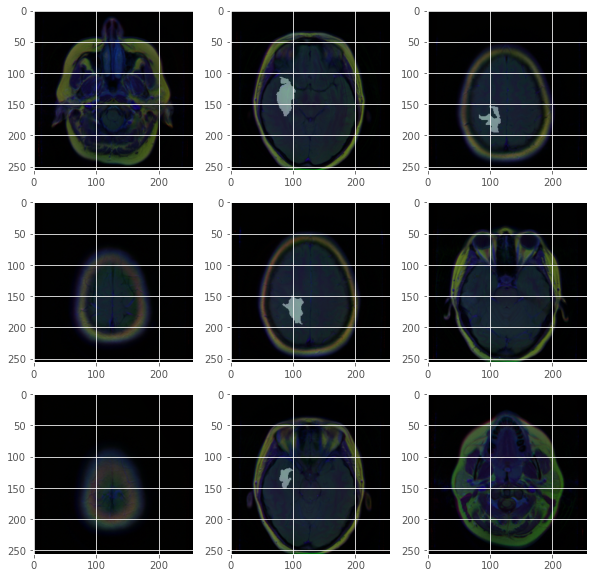

In [ ]:
# Visualizing the datasets
rows,cols=3,3
fig=plt.figure(figsize=(10,10))
for i in range(1,rows*cols+1):
    fig.add_subplot(rows,cols,i)
    img_path=train_files[i]
    msk_path=mask_files[i]
    img=cv2.imread(img_path)
    img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    msk=cv2.imread(msk_path)
    plt.imshow(img)
    plt.imshow(msk,alpha=0.4)
plt.show()


In [ ]:
# Creating the dataframe of the training images and the mask files
df = pd.DataFrame(data={"filename": train_files, 'mask' : mask_files})
df_train, df_test = train_test_split(df,test_size = 0.1)
df_train, df_val = train_test_split(df_train,test_size = 0.2)
print(df_train.values.shape)
print(df_val.values.shape)
print(df_test.values.shape)

(2828, 2)
(708, 2)
(393, 2)


In [ ]:
# Creating the data generator to load the dataset
def train_generator(data_frame, batch_size, aug_dict,
        image_color_mode="rgb",
        mask_color_mode="grayscale",
        image_save_prefix="image",
        mask_save_prefix="mask",
        save_to_dir=None,
        target_size=(256,256),
        seed=1):

    image_datagen = ImageDataGenerator(**aug_dict)
    mask_datagen = ImageDataGenerator(**aug_dict)
    
    # Using flow from dataframe in order to load images from folder
    image_generator = image_datagen.flow_from_dataframe(
        data_frame,
        x_col = "filename",
        class_mode = None,
        color_mode = image_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = image_save_prefix,
        seed = seed)
    
    # Using flow from dataframe in order to load images from folder
    mask_generator = mask_datagen.flow_from_dataframe(
        data_frame,
        x_col = "mask",
        class_mode = None,
        color_mode = mask_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = mask_save_prefix,
        seed = seed)
    
    # zipping both the generators so as to load them together
    train_gen = zip(image_generator, mask_generator)
    
    for (img, mask) in train_gen:
        img, mask = adjust_data(img, mask)
        yield (img,mask)

def adjust_data(img,mask):
    img = img / 255
    mask = mask / 255
    mask[mask > 0.5] = 1
    mask[mask <= 0.5] = 0
    
    return (img, mask)

In [ ]:
# Defining the loss functions for image segmentation. Dice coefficient, and IOU

smooth=100

def dice_coef(y_true, y_pred):
    y_truef=K.flatten(y_true)
    y_predf=K.flatten(y_pred)
    And=K.sum(y_truef* y_predf)
    return((2* And + smooth) / (K.sum(y_truef) + K.sum(y_predf) + smooth))

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

def iou(y_true, y_pred):
    intersection = K.sum(y_true * y_pred)
    sum_ = K.sum(y_true + y_pred)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return jac

def jac_distance(y_true, y_pred):
    y_truef=K.flatten(y_true)
    y_predf=K.flatten(y_pred)

    return - iou(y_true, y_pred)


In [ ]:
# Defining the U net model for image segmentation
def unet(input_size=(256,256,3)):
    inputs = Input(input_size)
    
    conv1 = Conv2D(64, (3, 3), padding='same')(inputs)
    bn1 = Activation('relu')(conv1)
    conv1 = Conv2D(64, (3, 3), padding='same')(bn1)
    bn1 = BatchNormalization(axis=3)(conv1)
    bn1 = Activation('relu')(bn1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(bn1)

    conv2 = Conv2D(128, (3, 3), padding='same')(pool1)
    bn2 = Activation('relu')(conv2)
    conv2 = Conv2D(128, (3, 3), padding='same')(bn2)
    bn2 = BatchNormalization(axis=3)(conv2)
    bn2 = Activation('relu')(bn2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(bn2)

    conv3 = Conv2D(256, (3, 3), padding='same')(pool2)
    bn3 = Activation('relu')(conv3)
    conv3 = Conv2D(256, (3, 3), padding='same')(bn3)
    bn3 = BatchNormalization(axis=3)(conv3)
    bn3 = Activation('relu')(bn3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(bn3)

    conv4 = Conv2D(512, (3, 3), padding='same')(pool3)
    bn4 = Activation('relu')(conv4)
    conv4 = Conv2D(512, (3, 3), padding='same')(bn4)
    bn4 = BatchNormalization(axis=3)(conv4)
    bn4 = Activation('relu')(bn4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(bn4)

    conv5 = Conv2D(1024, (3, 3), padding='same')(pool4)
    bn5 = Activation('relu')(conv5)
    conv5 = Conv2D(1024, (3, 3), padding='same')(bn5)
    bn5 = BatchNormalization(axis=3)(conv5)
    bn5 = Activation('relu')(bn5)

    up6 = concatenate([Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(bn5), conv4], axis=3)
    conv6 = Conv2D(512, (3, 3), padding='same')(up6)
    bn6 = Activation('relu')(conv6)
    conv6 = Conv2D(512, (3, 3), padding='same')(bn6)
    bn6 = BatchNormalization(axis=3)(conv6)
    bn6 = Activation('relu')(bn6)

    up7 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(bn6), conv3], axis=3)
    conv7 = Conv2D(256, (3, 3), padding='same')(up7)
    bn7 = Activation('relu')(conv7)
    conv7 = Conv2D(256, (3, 3), padding='same')(bn7)
    bn7 = BatchNormalization(axis=3)(conv7)
    bn7 = Activation('relu')(bn7)

    up8 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(bn7), conv2], axis=3)
    conv8 = Conv2D(128, (3, 3), padding='same')(up8)
    bn8 = Activation('relu')(conv8)
    conv8 = Conv2D(128, (3, 3), padding='same')(bn8)
    bn8 = BatchNormalization(axis=3)(conv8)
    bn8 = Activation('relu')(bn8)

    up9 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(bn8), conv1], axis=3)
    conv9 = Conv2D(64, (3, 3), padding='same')(up9)
    bn9 = Activation('relu')(conv9)
    conv9 = Conv2D(64, (3, 3), padding='same')(bn9)
    bn9 = BatchNormalization(axis=3)(conv9)
    bn9 = Activation('relu')(bn9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(bn9)

    return Model(inputs=[inputs], outputs=[conv10])

In [ ]:
model = unet()
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
activation (Activation)         (None, 256, 256, 64) 0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 64) 36928       activation[0][0]                 
_______________________________________________________________________________________

In [ ]:
# defining the parameters for model training.
EPOCHS = 150
BATCH_SIZE = 32
learning_rate = 1e-4


In [ ]:
# Training the model
train_generator_args = dict(rotation_range=0.2,
                            width_shift_range=0.05,
                            height_shift_range=0.05,
                            shear_range=0.05,
                            zoom_range=0.05,
                            horizontal_flip=True,
                            fill_mode='nearest')
train_gen = train_generator(df_train, BATCH_SIZE,
                                train_generator_args,
                                target_size=(im_height, im_width))
    
test_gener = train_generator(df_val, BATCH_SIZE,
                                dict(),
                                target_size=(im_height, im_width))
    
model = unet(input_size=(im_height, im_width, 3))



decay_rate = learning_rate / EPOCHS
opt = Adam(lr=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=None, decay=decay_rate, amsgrad=False)
model.compile(optimizer=opt, loss=dice_coef_loss, metrics=["binary_accuracy", iou, dice_coef])

callbacks = [ModelCheckpoint('unet_brain_mri_seg.hdf5', verbose=1, save_best_only=True)]

history = model.fit(train_gen,
                    steps_per_epoch=len(df_train) / BATCH_SIZE, 
                    epochs=EPOCHS, 
                    callbacks=callbacks,
                    validation_data = test_gener,
                    validation_steps=len(df_val) / BATCH_SIZE)

Found 2828 validated image filenames.
Found 2828 validated image filenames.
Epoch 1/150
89/88 [==============================] - ETA: 0s - loss: -0.1034 - binary_accuracy: 0.8898 - iou: 0.0562 - dice_coef: 0.1045Found 708 validated image filenames.
Found 708 validated image filenames.

Epoch 00001: val_loss improved from inf to -0.02726, saving model to unet_brain_mri_seg.hdf5
89/88 [==============================] - 104s 1s/step - loss: -0.1034 - binary_accuracy: 0.8898 - iou: 0.0562 - dice_coef: 0.1045 - val_loss: -0.0273 - val_binary_accuracy: 0.9139 - val_iou: 0.0145 - val_dice_coef: 0.0285
Epoch 2/150
89/88 [==============================] - ETA: 0s - loss: -0.1765 - binary_accuracy: 0.9818 - iou: 0.0979 - dice_coef: 0.1764
Epoch 00002: val_loss improved from -0.02726 to -0.04911, saving model to unet_brain_mri_seg.hdf5
89/88 [==============================] - 91s 1s/step - loss: -0.1765 - binary_accuracy: 0.9818 - iou: 0.0979 - dice_coef: 0.1764 - val_loss: -0.0491 - val_binary_a

Epoch 19/150
89/88 [==============================] - ETA: 0s - loss: -0.8080 - binary_accuracy: 0.9971 - iou: 0.6808 - dice_coef: 0.8058
Epoch 00019: val_loss improved from -0.81352 to -0.81690, saving model to unet_brain_mri_seg.hdf5
89/88 [==============================] - 89s 997ms/step - loss: -0.8080 - binary_accuracy: 0.9971 - iou: 0.6808 - dice_coef: 0.8058 - val_loss: -0.8169 - val_binary_accuracy: 0.9968 - val_iou: 0.6851 - val_dice_coef: 0.8081
Epoch 20/150
89/88 [==============================] - ETA: 0s - loss: -0.8024 - binary_accuracy: 0.9969 - iou: 0.6752 - dice_coef: 0.8019
Epoch 00020: val_loss improved from -0.81690 to -0.84145, saving model to unet_brain_mri_seg.hdf5
89/88 [==============================] - 91s 1s/step - loss: -0.8024 - binary_accuracy: 0.9969 - iou: 0.6752 - dice_coef: 0.8019 - val_loss: -0.8415 - val_binary_accuracy: 0.9969 - val_iou: 0.7263 - val_dice_coef: 0.8397
Epoch 21/150
89/88 [==============================] - ETA: 0s - loss: -0.0821 - bin

89/88 [==============================] - ETA: 0s - loss: -0.1358 - binary_accuracy: 0.9806 - iou: 0.0826 - dice_coef: 0.1349
Epoch 00038: val_loss did not improve from -0.87460
89/88 [==============================] - 90s 1s/step - loss: -0.1358 - binary_accuracy: 0.9806 - iou: 0.0826 - dice_coef: 0.1349 - val_loss: -0.6093 - val_binary_accuracy: 0.9862 - val_iou: 0.4590 - val_dice_coef: 0.6196
Epoch 39/150
89/88 [==============================] - ETA: 0s - loss: -0.8607 - binary_accuracy: 0.9973 - iou: 0.7624 - dice_coef: 0.8607
Epoch 00039: val_loss improved from -0.87460 to -0.87621, saving model to unet_brain_mri_seg.hdf5
89/88 [==============================] - 89s 1s/step - loss: -0.8607 - binary_accuracy: 0.9973 - iou: 0.7624 - dice_coef: 0.8607 - val_loss: -0.8762 - val_binary_accuracy: 0.9976 - val_iou: 0.7867 - val_dice_coef: 0.8785
Epoch 40/150
89/88 [==============================] - ETA: 0s - loss: -0.8822 - binary_accuracy: 0.9979 - iou: 0.7937 - dice_coef: 0.8822
Epoch 0

Epoch 58/150
89/88 [==============================] - ETA: 0s - loss: -0.8874 - binary_accuracy: 0.9978 - iou: 0.8007 - dice_coef: 0.8873
Epoch 00058: val_loss did not improve from -0.90598
89/88 [==============================] - 90s 1s/step - loss: -0.8874 - binary_accuracy: 0.9978 - iou: 0.8007 - dice_coef: 0.8873 - val_loss: -0.8990 - val_binary_accuracy: 0.9977 - val_iou: 0.8175 - val_dice_coef: 0.8984
Epoch 59/150
89/88 [==============================] - ETA: 0s - loss: -0.8893 - binary_accuracy: 0.9979 - iou: 0.8024 - dice_coef: 0.8883
Epoch 00059: val_loss did not improve from -0.90598
89/88 [==============================] - 89s 1s/step - loss: -0.8893 - binary_accuracy: 0.9979 - iou: 0.8024 - dice_coef: 0.8883 - val_loss: -0.6274 - val_binary_accuracy: 0.9940 - val_iou: 0.4965 - val_dice_coef: 0.6399
Epoch 60/150
89/88 [==============================] - ETA: 0s - loss: -0.8923 - binary_accuracy: 0.9980 - iou: 0.8095 - dice_coef: 0.8925
Epoch 00060: val_loss did not improve fr

Epoch 78/150
89/88 [==============================] - ETA: 0s - loss: -0.9061 - binary_accuracy: 0.9982 - iou: 0.8311 - dice_coef: 0.9063
Epoch 00078: val_loss did not improve from -0.90598
89/88 [==============================] - 98s 1s/step - loss: -0.9061 - binary_accuracy: 0.9982 - iou: 0.8311 - dice_coef: 0.9063 - val_loss: -0.9002 - val_binary_accuracy: 0.9978 - val_iou: 0.8081 - val_dice_coef: 0.8851
Epoch 79/150
89/88 [==============================] - ETA: 0s - loss: -0.9036 - binary_accuracy: 0.9982 - iou: 0.8261 - dice_coef: 0.9035
Epoch 00079: val_loss did not improve from -0.90598
89/88 [==============================] - 97s 1s/step - loss: -0.9036 - binary_accuracy: 0.9982 - iou: 0.8261 - dice_coef: 0.9035 - val_loss: -0.8940 - val_binary_accuracy: 0.9977 - val_iou: 0.8142 - val_dice_coef: 0.8962
Epoch 80/150
89/88 [==============================] - ETA: 0s - loss: -0.9027 - binary_accuracy: 0.9982 - iou: 0.8302 - dice_coef: 0.9029
Epoch 00080: val_loss did not improve fr

Epoch 98/150
89/88 [==============================] - ETA: 0s - loss: -0.9096 - binary_accuracy: 0.9983 - iou: 0.8369 - dice_coef: 0.9097
Epoch 00098: val_loss did not improve from -0.90636
89/88 [==============================] - 100s 1s/step - loss: -0.9096 - binary_accuracy: 0.9983 - iou: 0.8369 - dice_coef: 0.9097 - val_loss: -0.8937 - val_binary_accuracy: 0.9976 - val_iou: 0.8120 - val_dice_coef: 0.8950
Epoch 99/150
89/88 [==============================] - ETA: 0s - loss: -0.9086 - binary_accuracy: 0.9982 - iou: 0.8369 - dice_coef: 0.9085
Epoch 00099: val_loss did not improve from -0.90636
89/88 [==============================] - 100s 1s/step - loss: -0.9086 - binary_accuracy: 0.9982 - iou: 0.8369 - dice_coef: 0.9085 - val_loss: -0.8863 - val_binary_accuracy: 0.9978 - val_iou: 0.8009 - val_dice_coef: 0.8876
Epoch 100/150
89/88 [==============================] - ETA: 0s - loss: -0.9014 - binary_accuracy: 0.9981 - iou: 0.8254 - dice_coef: 0.9014
Epoch 00100: val_loss did not improve

Epoch 118/150
89/88 [==============================] - ETA: 0s - loss: -0.8917 - binary_accuracy: 0.9980 - iou: 0.8122 - dice_coef: 0.8911
Epoch 00118: val_loss did not improve from -0.90894
89/88 [==============================] - 100s 1s/step - loss: -0.8917 - binary_accuracy: 0.9980 - iou: 0.8122 - dice_coef: 0.8911 - val_loss: -0.8965 - val_binary_accuracy: 0.9978 - val_iou: 0.8128 - val_dice_coef: 0.8958
Epoch 119/150
89/88 [==============================] - ETA: 0s - loss: -0.4084 - binary_accuracy: 0.9884 - iou: 0.2999 - dice_coef: 0.4056
Epoch 00119: val_loss did not improve from -0.90894
89/88 [==============================] - 97s 1s/step - loss: -0.4084 - binary_accuracy: 0.9884 - iou: 0.2999 - dice_coef: 0.4056 - val_loss: -0.8624 - val_binary_accuracy: 0.9970 - val_iou: 0.7566 - val_dice_coef: 0.8534
Epoch 120/150
89/88 [==============================] - ETA: 0s - loss: -0.9124 - binary_accuracy: 0.9983 - iou: 0.8419 - dice_coef: 0.9123
Epoch 00120: val_loss did not improv

Epoch 138/150
89/88 [==============================] - ETA: 0s - loss: -0.0513 - binary_accuracy: 0.9797 - iou: 0.0293 - dice_coef: 0.0511
Epoch 00138: val_loss did not improve from -0.91435
89/88 [==============================] - 117s 1s/step - loss: -0.0513 - binary_accuracy: 0.9797 - iou: 0.0293 - dice_coef: 0.0511 - val_loss: -0.6086 - val_binary_accuracy: 0.9865 - val_iou: 0.4370 - val_dice_coef: 0.6018
Epoch 139/150
89/88 [==============================] - ETA: 0s - loss: -0.8899 - binary_accuracy: 0.9974 - iou: 0.8136 - dice_coef: 0.8893
Epoch 00139: val_loss did not improve from -0.91435
89/88 [==============================] - 95s 1s/step - loss: -0.8899 - binary_accuracy: 0.9974 - iou: 0.8136 - dice_coef: 0.8893 - val_loss: -0.9014 - val_binary_accuracy: 0.9979 - val_iou: 0.8220 - val_dice_coef: 0.9012
Epoch 140/150
89/88 [==============================] - ETA: 0s - loss: -0.9042 - binary_accuracy: 0.9982 - iou: 0.8286 - dice_coef: 0.9043
Epoch 00140: val_loss did not improv

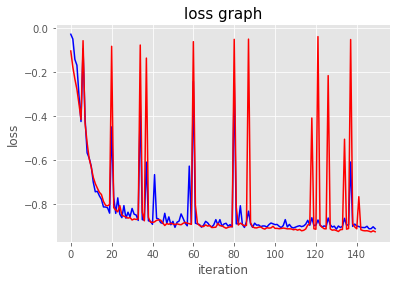

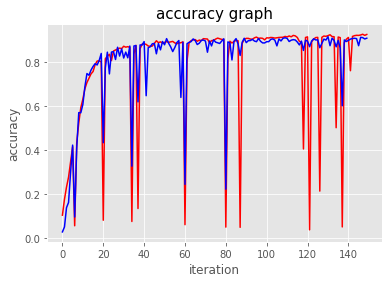

In [ ]:
# Visualizing the model performance
a = history.history

list_traindice = a['dice_coef']
list_testdice = a['val_dice_coef']

list_trainjaccard = a['iou']
list_testjaccard = a['val_iou']

list_trainloss = a['loss']
list_testloss = a['val_loss']
plt.figure(1)
plt.plot(list_testloss, 'b-')
plt.plot(list_trainloss,'r-')
plt.xlabel('iteration')
plt.ylabel('loss')
plt.title('loss graph', fontsize = 15)
plt.figure(2)
plt.plot(list_traindice, 'r-')
plt.plot(list_testdice, 'b-')
plt.xlabel('iteration')
plt.ylabel('accuracy')
plt.title('accuracy graph', fontsize = 15)
plt.show()